In [ ]:
!pip install transformers

     |████████████████████████████████| 1.9MB 9.6MB/s 
     |████████████████████████████████| 890kB 50.8MB/s 
     |████████████████████████████████| 3.2MB 48.9MB/s 
  Created wheel for sacremoses: filename=sacremoses-0.0.43-cp37-none-any.whl size=893262 sha256=aa799dd9ecff90e2d2fd78194108f1fe75e7b1f5198bfe9da1488c17a02de33a
  Stored in directory: /root/.cache/pip/wheels/29/3c/fd/7ce5c3f0666dab31a50123635e6fb5e19ceb42ce38d4e58f45
Successfully built sacremoses


In [ ]:
import torch
from transformers import BertConfig,BertTokenizer,BertModel

## BERT Model

In [ ]:
model_type = 'bert-base-uncased'
config = BertConfig.from_pretrained(model_type)
config.output_attentions=True
model = BertModel.from_pretrained(model_type,config = config).to('cuda')
tokenizer = BertTokenizer.from_pretrained(model_type)

### Sample text

In [ ]:
text1 = 'we met today and she wanted to meet'
text2 = 'again.'
tok1 = tokenizer.tokenize(text1)
tok2 = tokenizer.tokenize(text2)

p_pos = len(tok1) # position for token
tok = tok1+tok2

tok,p_pos,tok[p_pos]


(['we', 'met', 'today', 'and', 'she', 'wanted', 'to', 'meet', 'again'],
 7,
 'meet')

### Forward

In [ ]:
ids = torch.tensor(tokenizer.convert_tokens_to_ids(tok)).unsqueeze(0).to('cuda')
with torch.no_grad():
    output = model(ids)
attentions = torch.cat(output[2]).to('cpu')
attentions.shape #(layer, batch_size (squeezed by torch.cat), num_heads, sequence_length, sequence_length)

torch.Size([12, 12, 9, 9])

### Extract Attention Weights

In [ ]:
attentions = attentions.permute(2,1,0,3)
print(attentions.shape) #(sequence_length, num_heads, layer, sequence_length)

torch.Size([9, 12, 12, 9])


In [ ]:
layers = len(attentions[0][0])
heads = len(attentions[0])
seqlen = len(attentions)
layers,heads,seqlen

(12, 12, 9)

### Extract Attention for tokens

In [ ]:
attentions_pos = attentions[p_pos]
attentions_pos.shape

torch.Size([12, 12, 9])

### Plot

Attention weights for token "meet"


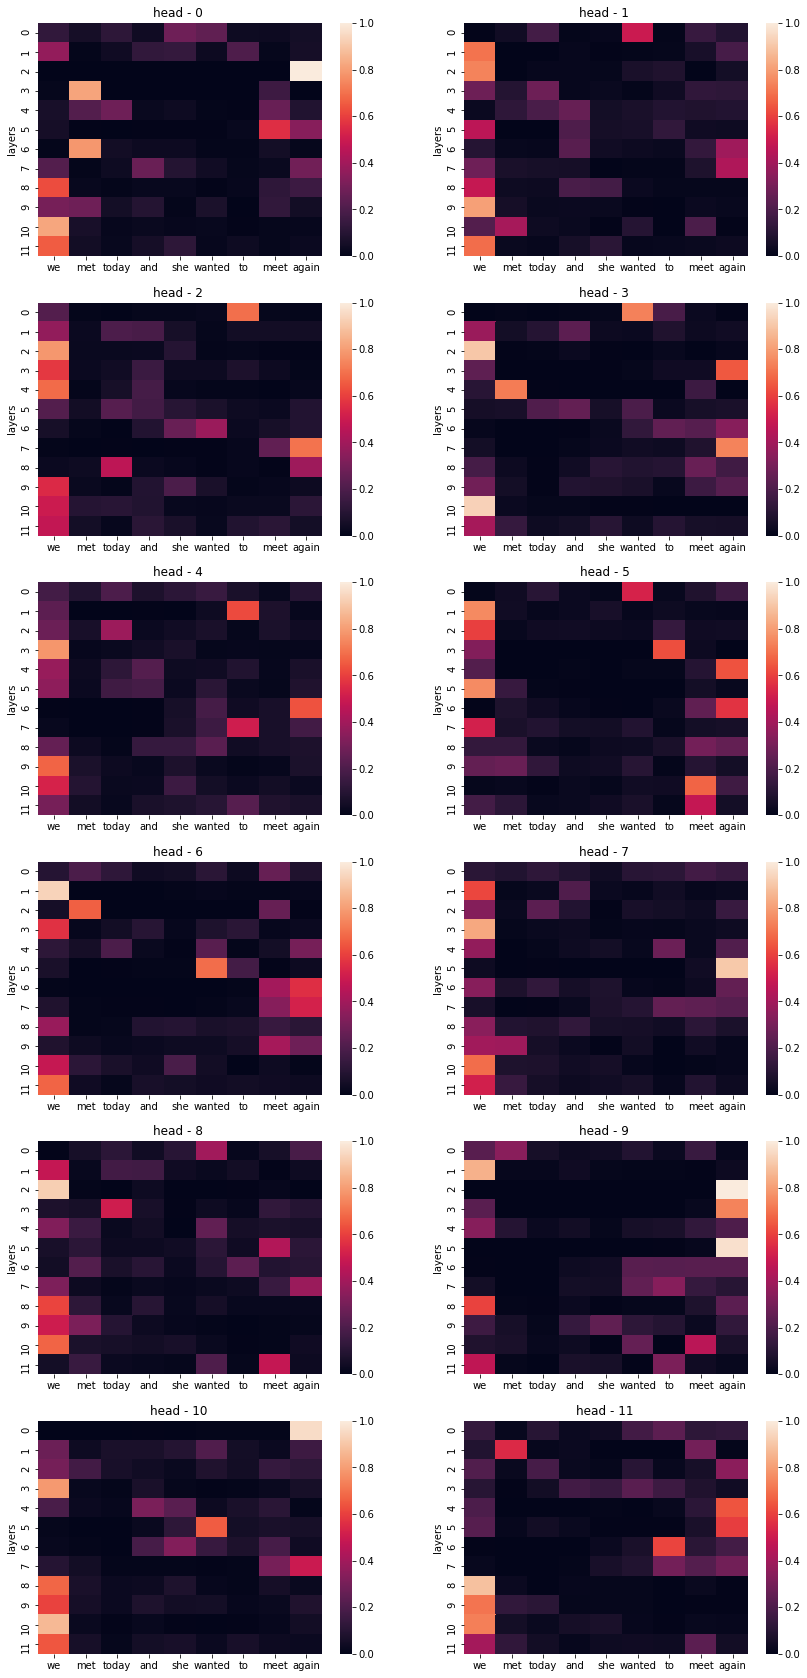

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
cols = 2
rows = int(heads/cols)

fig, axes = plt.subplots( rows,cols, figsize = (14,30))
axes = axes.flat
print (f'Attention weights for token "{tok[p_pos]}"')
for i,att in enumerate(attentions_pos):

    #im = axes[i].imshow(att, cmap='gray')
    sns.heatmap(att,vmin = 0, vmax = 1,ax = axes[i], xticklabels = tok)
    axes[i].set_title(f'head - {i} ' )
    axes[i].set_ylabel('layers')